# [Issue2](https://github.com/yoavram/curveball/issues/2) 
Check that the best fit is better than a linear regression or log-linear regression in terms of BIC. 

BIC thresholds taken from 2nd table in pg. 777 in [Kass, Robert E.; Raftery, Adrian E. (1995), "Bayes Factors", Journal of the American Statistical Association 90 (430): 773–795, doi:10.2307/2291091](https://www.stat.washington.edu/raftery/Research/PDF/kass1995.pdf)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("ticks")
sns.set_context('notebook')
import curveball
import io
from lmfit import Model

In [2]:
content="""
,Time [s],Strain,OD,Media,Time
0,0,t153,0.11199999999999999,Y6P,0.0
1,3640,t153,0.11199999999999999,Y6P,1.011111111111111
2,7279,t153,0.115,Y6P,2.0219444444444443
3,10919,t153,0.11800000000000001,Y6P,3.0330555555555554
4,14559,t153,0.125,Y6P,4.0441666666666665
5,18198,t153,0.13,Y6P,5.055
6,21838,t153,0.134,Y6P,6.066111111111111
7,25478,t153,0.136,Y6P,7.077222222222222
8,29117,t153,0.139,Y6P,8.088055555555556
9,32757,t153,0.14,Y6P,9.099166666666667
10,36397,t153,0.142,Y6P,10.110277777777778
11,40036,t153,0.14300000000000002,Y6P,11.12111111111111
12,43676,t153,0.14400000000000002,Y6P,12.132222222222222
13,47316,t153,0.146,Y6P,13.143333333333333
14,50955,t153,0.147,Y6P,14.154166666666667
90,0,t153,0.111,Y6P,0.0
91,3640,t153,0.111,Y6P,1.011111111111111
92,7279,t153,0.113,Y6P,2.0219444444444443
93,10919,t153,0.11800000000000001,Y6P,3.0330555555555554
94,14559,t153,0.12300000000000001,Y6P,4.0441666666666665
95,18198,t153,0.13,Y6P,5.055
96,21838,t153,0.134,Y6P,6.066111111111111
97,25478,t153,0.138,Y6P,7.077222222222222
98,29117,t153,0.141,Y6P,8.088055555555556
99,32757,t153,0.14400000000000002,Y6P,9.099166666666667
100,36397,t153,0.146,Y6P,10.110277777777778
101,40036,t153,0.147,Y6P,11.12111111111111
102,43676,t153,0.149,Y6P,12.132222222222222
103,47316,t153,0.151,Y6P,13.143333333333333
104,50955,t153,0.153,Y6P,14.154166666666667
"""

In [3]:
df = pd.read_csv(io.BytesIO(content), index_col=0)
df.head()

,Time [s],Strain,OD,Media,Time
0,0,t153,0.112,Y6P,0.000000
1,3640,t153,0.112,Y6P,1.011111
2,7279,t153,0.115,Y6P,2.021944
3,10919,t153,0.118,Y6P,3.033056
4,14559,t153,0.125,Y6P,4.044167


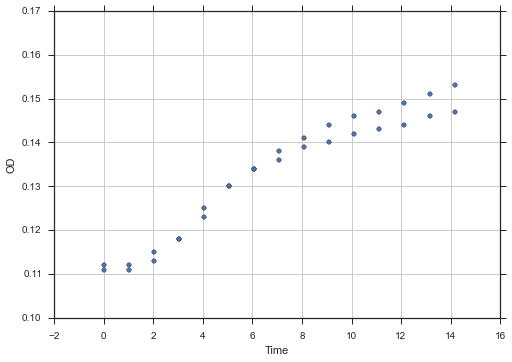

In [4]:
df.plot('Time', 'OD', kind="scatter")

[[Model]]
    Model(baranyi_roberts_function)
[[Fit Statistics]]
    # function evals   = 230
    # data points      = 15
    # variables        = 5
    chi-square         = 1.352
    reduced chi-square = 0.135
[[Variables]]
    y0:   0.11141760 +/- 0.000224 (0.20%) (init= 0.1115)
    r:    0.27634027 +/- 0.018406 (6.66%) (init= 0.04396007)
    K:    0.14978110 +/- 0.001057 (0.71%) (init= 0.15)
    nu:   1 (fixed)
    q0:   0.00901964 +/- 0.011051 (122.53%) (init= 1)
    v:    2.16199785 +/- 0.633322 (29.29%) (init= 1)



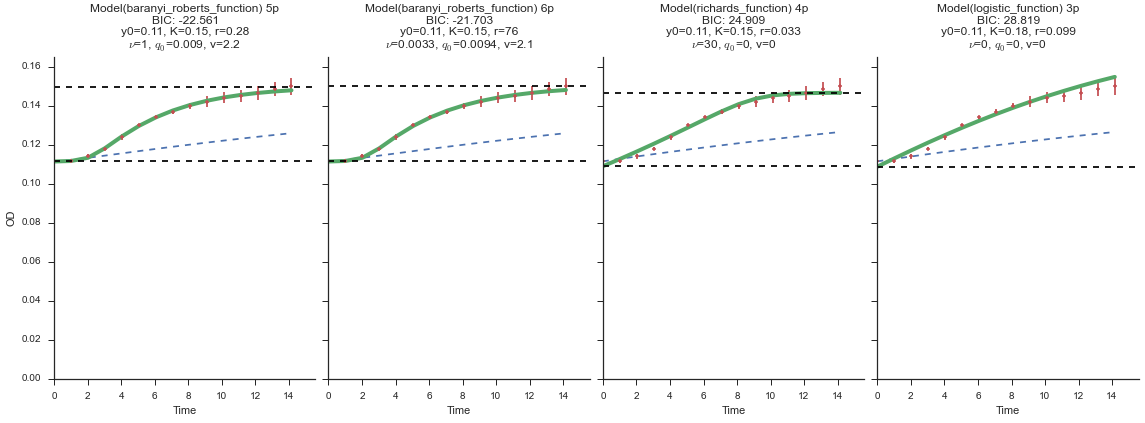

In [5]:
models,fig,ax = curveball.models.fit_model(df)

In [6]:
_df = df.groupby('Time')['OD'].agg([np.mean, np.std]).reset_index().rename(columns={'mean':'OD'})

# if there is more than one replicate, use the standard deviation as weight
if np.isnan(_df['std']).any():
    print "Warning: NaN in standard deviation, can't use weights"
    weights = None
else:
    weights = 1./_df['std']
    # if any weight is nan, raise error
    idx = np.isnan(weights)
    if idx.any():
        raise ValueError("NaN weights are illegal, indices: " + str(idx))
    # if any weight is infinite, change to the max
    idx = np.isinf(weights)
    if idx.any():
        print "Warning: found infinite weight, changing to maximum (%d occurences)" % idx.sum()
        weights[idx] = weights[~idx].max()

In [8]:
dydt = np.gradient(_df.OD, _df.Time)
idx = (~np.isinf(dydt)) & (~np.isnan(dydt)) # dydt not nan or inf
aguess  = dydt[idx].mean()
y0guess = _df.OD.min()
y0guess, aguess

(0.1115, 0.00065276908072644092)

In [23]:
#def linear_function(t, y0, a):
#    return y0 + a * t
#linear_model = Model(linear_function)
from lmfit.models import LinearModel
linear_model = LinearModel()

[-22.561348861239296, -21.703153401048471, 24.908953199589554, 28.818776120742399] 29.3414487625
[True, True, False, False]


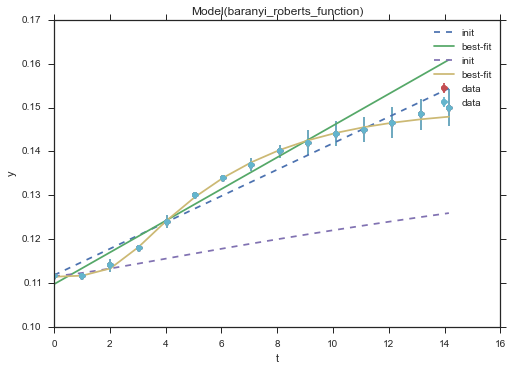

In [25]:
#params = linear_model.make_params(intercept=y0guess, slope=aguess)
params = linear_model.guess(_df.OD, x=_df.Time)
fit = linear_model.fit(data=_df.OD, x=_df.Time, params=params, weights=weights)
fit.plot_fit()
models[0].plot_fit()
print [m.bic for m in models], fit.bic
print [m.bic+10 < fit.bic for m in models]